In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# A/B base class

In [2]:
class ABBase():
    
    def __init__(self, alpha = 0.05, power = 0.8):
        self.alpha = alpha
        self.power = power
    
    def calc_variance_sample_size(self):
        pass
    
    def sample_size_calculator(self):
        self.calc_variance_for_sample_size()
        standard_norm = st.norm(0, 1)
        Z_beta = standard_norm.ppf(self.power)
        Z_alpha = standard_norm.ppf(1-self.alpha/2)
        min_N = (Z_beta + Z_alpha)**2*(self.baseline_var + self.treatment_var)/self.mde**2
        return int(np.round(min_N, 0))
    
    def pre_experiment_stats(self):
        min_N = self.sample_size_calculator()
        print('=========================================')
        print('Alpha:\t\t\t\t{:.2f}'.format(self.alpha))
        print('Power:\t\t\t\t{:.2f}'.format(self.power))
        print('Baseline value:\t\t\t{:.7f}'.format(self.baseline_value))
        print('Minimum detectable effect:\t{:.7f}'.format(self.mde))
        print('Treatment value:\t\t{:.7f}'.format(self.treatment_value))
        print('Minimum sample size:\t\t{}'.format(min_N))
        print('=========================================')
    
    def calc_var(self):
        pass
    
    def return_sample_stats(self):
        self.calc_var()
        print('=================================')
        print('============ Control ============')
        print('Sample size:\t\t{}'.format(self.N_c))
        print('Conversion rate:\t{:.7f}'.format(self.val_c))
        print('Standard deviation:\t{:.7f}'.format(self.var_c))
        print('=================================')
        print('=========== Treatment ===========')
        print('Sample size:\t\t{}'.format(self.N_t))
        print('Conversion rate:\t{:.7f}'.format(self.val_t))
        print('Standard deviation:\t{:.7f}'.format(self.var_t))

    def calc_std_error(self):
        self.std_error_c = np.sqrt(self.var_c)/np.sqrt(self.N_c)
        self.std_error_t = np.sqrt(self.var_t)/np.sqrt(self.N_t)
        
    def calc_pooled_std_error(self):
        self.pooled_std_error = np.sqrt(self.std_error_c**2.0 + self.std_error_t**2.0)
    
    def calc_t_stat(self):
        self.t_stat =  (self.val_t - self.val_c) / self.pooled_std_error
        
    def t_statistic(self):
        self.calc_var()
        self.calc_std_error()
        self.calc_pooled_std_error()
        self.calc_t_stat()
        return self.t_stat

    def stat_power_calc(self):
#         self.alpha_line = st.norm.ppf(q = 1-self.alpha/2, loc = 0, scale = self.pooled_std_error)
#         self.stat_power = 1-st.norm.cdf(self.alpha_line, loc = self.conv_t - self.conv_c, scale = self.pooled_std_error)
        self.stat_power = st.norm(0, 1).cdf((self.val_t - self.val_c)/self.pooled_std_error-st.norm(0, 1).ppf(1-self.alpha/2))
    
    def hypothesis_testing(self, test_type = 'two-sided'):
        self.t_statistic()
        self.df = self.N_c+self.N_t-2
        if test_type == 'two-sided':
            self.p = (1.0 - st.norm.cdf(abs(self.t_stat))) * 2.0
        elif test_type == 'one-sided':
            self.p = (1.0 - st.norm.cdf(abs(self.t_stat)))
        if self.p > self.alpha:
            print("p = {:.4f}. We fail to reject the Null hypothesis on significance level: {:.0f}%.".format(self.p, 100-100*self.alpha))
        else:
            print("p = {:.4f}. We reject the Null hypothesis. The difference is statistically significant on significance level: {:.0f}%.".format(self.p, 100-100*self.alpha))

    def hypothesis_summary(self):
        self.hypothesis_testing()
        self.stat_power_calc()        
        print('===============================================')
        print('test statistic:\t\t\t\t{:.4f}'.format(self.t_stat))
        print('Degrees of freedom:\t\t\t{:.0f}'.format(self.df))
        print('p-value (Probability of Type I error):\t{:.4f}'.format(self.p))
        print('Alpha:\t\t\t\t\t{}'.format(self.alpha))
        print('Beta (Probability of Type II error):\t{:.4f}'.format(1-self.stat_power))
        print('Power:\t\t\t\t\t{:.4f}'.format(self.stat_power))
        print('===============================================')

    def simulate_with_data(self):
        pass        
        
    def plot_hypothesis_distributions(self, green_line =False, blue_line = False, fig_size = (15,8)):
        plt.figure(figsize = fig_size)
        self.diff = self.val_t - self.val_c
        x_H0 = np.linspace(0-12 * self.pooled_std_error, 0 + 12 * self.pooled_std_error, 1000)
        x_H1 = np.linspace(self.diff-12 * self.pooled_std_error, self.diff + 12 * self.pooled_std_error, 1000)
        y_H0 = st.norm(0, self.pooled_std_error).pdf(x_H0)
        y_H1 = st.norm(self.diff, self.pooled_std_error).pdf(x_H1)
        plt.plot(x_H0, y_H0)
        plt.plot(x_H1, y_H1)
        if green_line == True:
            self.alpha_line = st.norm.ppf(q = 1-self.alpha/2, loc = 0, scale = self.pooled_std_error)
            plt.axvline(self.alpha_line, linestyle = '--', c = 'g')
        if blue_line == True:
            plt.axvline(self.diff, linestyle = '--', c = 'b')            
    
    def plot_groups_distributions(self):
        pass

# A/B conversion class

In [3]:
class ABConversion(ABBase):
    
    def __init__(self, N_c, N_t, conv_c, conv_t, alpha = 0.05, power = 0.8, baseline_value = None, min_det_effect = None):
        ABBase.__init__(self, alpha, power)
        self.N_c = N_c
        self.N_t = N_t
        self.val_c = conv_c
        self.val_t = conv_t
        self.baseline_value = baseline_value
        self.min_det_effect = min_det_effect
    
    def calc_variance_for_sample_size(self):
        self.baseline_conv = self.baseline_value
        self.treatment_conv = self.treatment_value = self.baseline_conv * (1 + self.min_det_effect)
        self.mde = self.treatment_conv - self.baseline_conv
        self.baseline_var = self.baseline_conv * (1 - self.baseline_conv)
        self.treatment_var = self.treatment_conv * (1 - self.treatment_conv)
    
    def calc_var(self):
        self.conv_c = self.val_c
        self.conv_t = self.val_t
        self.var_c = self.conv_c * (1-self.conv_c)
        self.var_t = self.conv_t * (1-self.conv_t)
    
    def simulate_with_data(self, eq_var = False):
        t, p = st.ttest_ind(st.bernoulli.rvs(p = self.conv_c, size = self.N_c),st.bernoulli.rvs(p = self.conv_t, size = self.N_t), equal_var = eq_var)
        print("t:\t", t, "\tp:\t", p)     
        
    def plot_groups_distributions(self, fig_size = (15,8)):
        plt.figure(figsize = fig_size)
        x_c = np.arange(st.binom.ppf(0.000001, N_c, self.conv_c), st.binom.ppf(0.999999, N_c, self.conv_c))
        x_t = np.arange(st.binom.ppf(0.000001, N_t, self.conv_t), st.binom.ppf(0.999999, N_t, self.conv_t))
        y_c = st.binom(self.N_c, self.conv_c).pmf(x_c)
        y_t = st.binom(self.N_t, self.conv_t).pmf(x_t)
        plt.plot(x_c, y_c)
        plt.plot(x_t, y_t)
    

# A/B mean class

In [4]:
class ABMean(ABBase):
    
    def __init__(self, data_c, data_t, alpha = 0.05, power = 0.8, baseline_value = None, min_det_effect = None, baseline_var = None, treatment_var = None):
        ABBase.__init__(self, alpha, power)
        self.data_c = data_c
        self.data_t = data_t
        self.N_c = len(data_c)
        self.N_t = len(data_t)
        self.val_c = np.mean(data_c)
        self.val_t = np.mean(data_t)
        self.baseline_value = baseline_value
        self.min_det_effect = min_det_effect
        self.baseline_var = baseline_var
        self.treatment_var = treatment_var
    
    def calc_variance_for_sample_size(self):
        self.baseline_mean = self.baseline_value
        self.treatment_mean = self.treatment_value = self.baseline_mean * (1 + self.min_det_effect)
        self.mde = self.treatment_mean - self.baseline_mean
    
    def calc_var(self):
        self.mean_c = self.val_c
        self.mean_t = self.val_t
        self.var_c = np.var(self.data_c)
        self.var_t = np.var(self.data_t)
    
    def plot_groups_distributions(self, fig_size = (15,8)):
        plt.figure(figsize = fig_size)
        plt.hist(data_c, bins = 100, alpha=0.5)  
        plt.hist(data_t, bins = 100, alpha=0.5)

## Proportions example

In [20]:
N_c = 61166
N_t = 59945

conv_c = 717/N_c
conv_t = 852/N_t

In [21]:
exp1 = ABConversion(N_c, N_t, conv_c, conv_t)

In [22]:
baseline_value = conv_c
# baseline_value = 0.0034737

min_det_effect = conv_t/conv_c-1
# min_det_effect = 0.5

exp1.baseline_value = baseline_value
exp1.min_det_effect = min_det_effect

In [24]:
exp1.pre_experiment_stats()

Alpha:				0.05
Power:				0.80
Baseline value:			0.0117222
Minimum detectable effect:	0.0024908
Treatment value:		0.0142130
Minimum sample size:		32381


In [25]:
exp1.return_sample_stats()

============ Control ============
Sample size:		61166
Conversion rate:	0.0117222
Standard deviation:	0.0115848
=========== Treatment ===========
Sample size:		59945
Conversion rate:	0.0142130
Standard deviation:	0.0140110


In [26]:
exp1.hypothesis_summary()

p = 0.0001. We reject the Null hypothesis. The difference is statistically significant on significance level: 95%.
test statistic:				3.8292
Degrees of freedom:			121109
p-value (Probability of Type I error):	0.0001
Alpha:					0.05
Beta (Probability of Type II error):	0.0308
Power:					0.9692


In [28]:
for i in range(10):
    exp1.simulate_with_data(eq_var = False)

t:	 -3.211242918518619 	p:	 0.0013219699501504168
t:	 -3.874788521729947 	p:	 0.00010677424181639607
t:	 -3.5356250001778644 	p:	 0.0004069652092960351
t:	 -2.8622934433516254 	p:	 0.004206600004470501
t:	 -2.7796200198279095 	p:	 0.005443099480747904
t:	 -2.6417406152632896 	p:	 0.008249186988316948
t:	 -2.7749209473466525 	p:	 0.005522365714336281
t:	 -4.857893110981248 	p:	 1.1879222954833411e-06
t:	 -2.281667614073755 	p:	 0.022510708688909163
t:	 -5.329703071821639 	p:	 9.855280434364356e-08


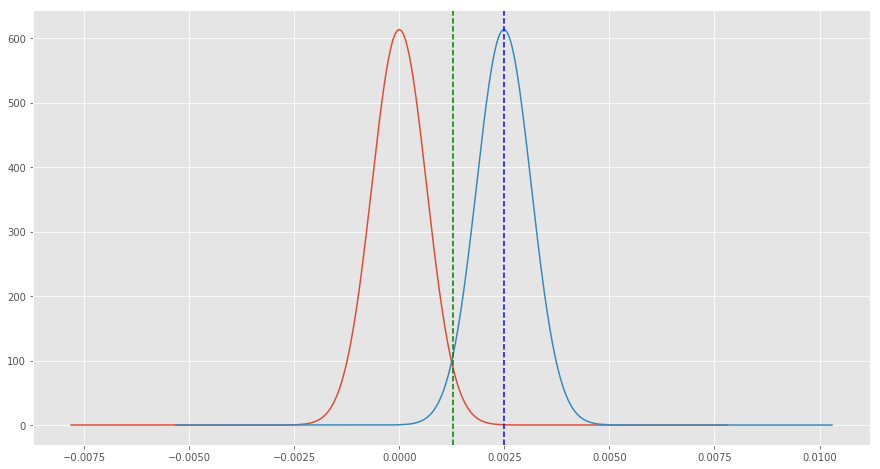

In [29]:
exp1.plot_hypothesis_distributions(green_line = True, blue_line=True)

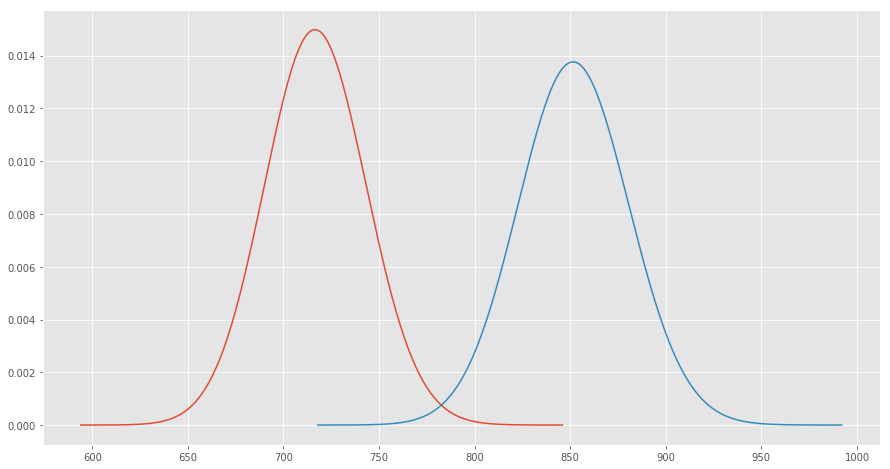

In [30]:
exp1.plot_groups_distributions()

## Means example

In [85]:
# read the data

# data_c = pd.read_csv("data1.csv")['val'].values
# data_t = pd.read_csv("data2.csv")['val'].values

In [153]:
mean_c = 60
mean_t = 70
stdev_c = 60
stdev_t = 70
N_c = 328
N_t = 328
data_c = np.random.normal(mean_c, stdev_c, N_c)
data_t = np.random.normal(mean_t, stdev_t, N_t)

In [154]:
exp2 = ABMean(data_c, data_t)

In [155]:
baseline_value = mean_c
# baseline_value = 3.22

min_det_effect = mean_t/mean_c-1
# min_det_effect = 0.5

baseline_var = stdev_c**2
# baseline_var = 7.5

treatment_var = stdev_t**2
# treatment_var = 7.5

exp2.baseline_value = baseline_value
exp2.min_det_effect = min_det_effect
exp2.baseline_var = baseline_var
exp2.treatment_var = treatment_var

In [156]:
exp2.pre_experiment_stats()

Alpha:				0.05
Power:				0.80
Baseline value:			60.0000000
Minimum detectable effect:	10.0000000
Treatment value:		70.0000000
Minimum sample size:		667


In [157]:
exp2.return_sample_stats()

============ Control ============
Sample size:		328
Conversion rate:	61.5082929
Standard deviation:	3590.1381960
=========== Treatment ===========
Sample size:		328
Conversion rate:	70.8784190
Standard deviation:	4345.0161505


In [158]:
exp2.hypothesis_summary()

p = 0.0568. We fail to reject the Null hypothesis on significance level: 95%.
test statistic:				1.9050
Degrees of freedom:			654
p-value (Probability of Type I error):	0.0568
Alpha:					0.05
Beta (Probability of Type II error):	0.5219
Power:					0.4781


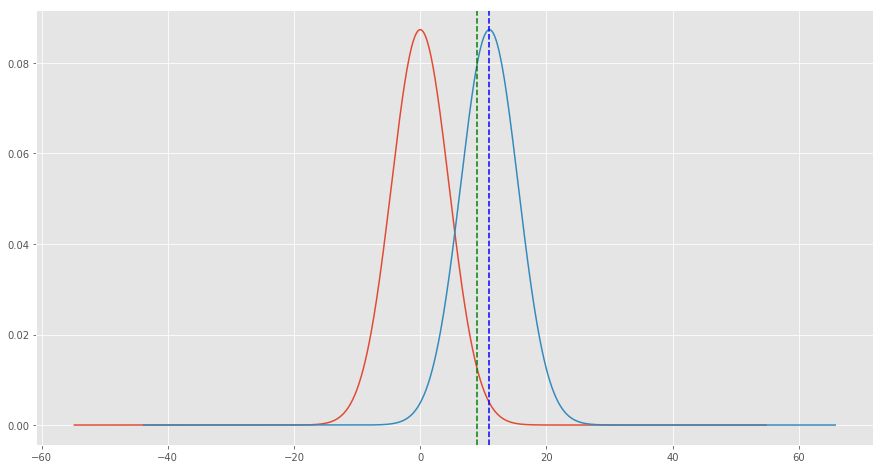

In [133]:
exp2.plot_hypothesis_distributions(green_line = True, blue_line=True)

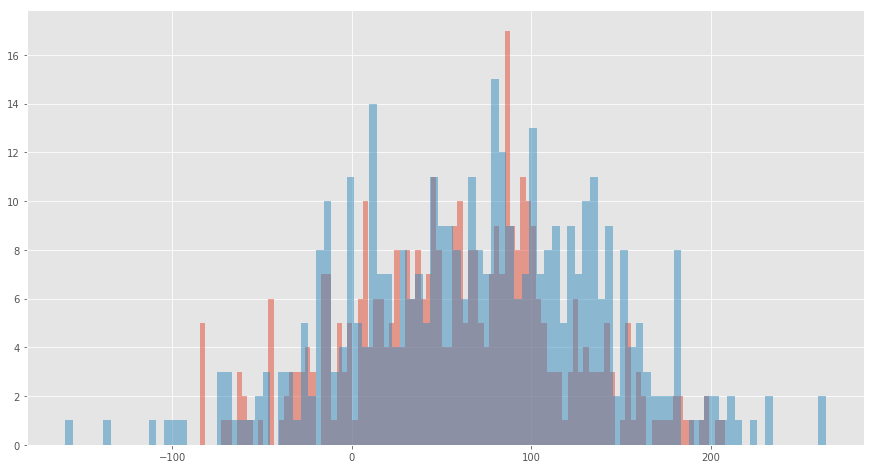

In [134]:
exp2.plot_groups_distributions()